In [ ]:
# ============================================
# ICD 2024 - Delgadillo_Julian
# Evaluación de Ciencia de Datos
# Fecha: 25 de octubre de 2023
# Descripción: Análisis de datos de reservas hoteleras utilizando modelos de clasificación.
# Fecha: 27 de octubre de 2023
# Descripción: Análisis de datos de reservas hoteleras utilizando modelos de clasificación.
# ============================================

# ============================================
# 1. Exploración: Importación de Librerías Necesarias
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para partición de datos y modelos
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Para métricas y evaluación
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Para preprocesamiento
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import chi2_contingency

# Configuración de visualizaciones
%matplotlib inline
sns.set_theme(style='darkgrid', palette='Set2')

In [ ]:
# ============================================
# 1.a. Exploración: Carga del Archivo Desde la Computadora, Leer el Archivo "hotel_bookings.csv"
# ============================================

# Intentar cargar el archivo desde Colab o un entorno local
try:
    from google.colab import files
    uploaded = files.upload()
    import io

    # Cargar el archivo como CSV sin 'error_bad_lines'
    file_name = next(iter(uploaded))
    df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding='utf-8', sep=',')

    print(f"Archivo '{file_name}' cargado correctamente.")
    print(df.head())

except ModuleNotFoundError:
    print("No se detectó Colab. Intentando cargar desde el sistema de archivos local...")
    # Cambia la ruta según tu entorno local
    df = pd.read_csv("ruta/al/archivo/hotel_bookings.csv", encoding='utf-8', sep=',')
    print("Archivo cargado desde el entorno local.")


Saving hotel_bookings.csv to hotel_bookings.csv
Archivo 'hotel_bookings.csv' cargado correctamente.
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  d

In [ ]:
# ============================================
# 1.a. Exploración de Datos: Estructura y Variables
# ============================================

# a. Información general del dataset
print("Información del DataFrame:")
df.info()

print("\nDescripción estadística de variables numéricas:")
df.describe()

# Identificar variables categóricas y numéricas
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nVariables categóricas:", categorical_features)
print("Variables numéricas:", numerical_features)

df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df['room_type_changed'] = (df['reserved_room_type'] != df['assigned_room_type']).astype(int)

print(df.describe())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  in

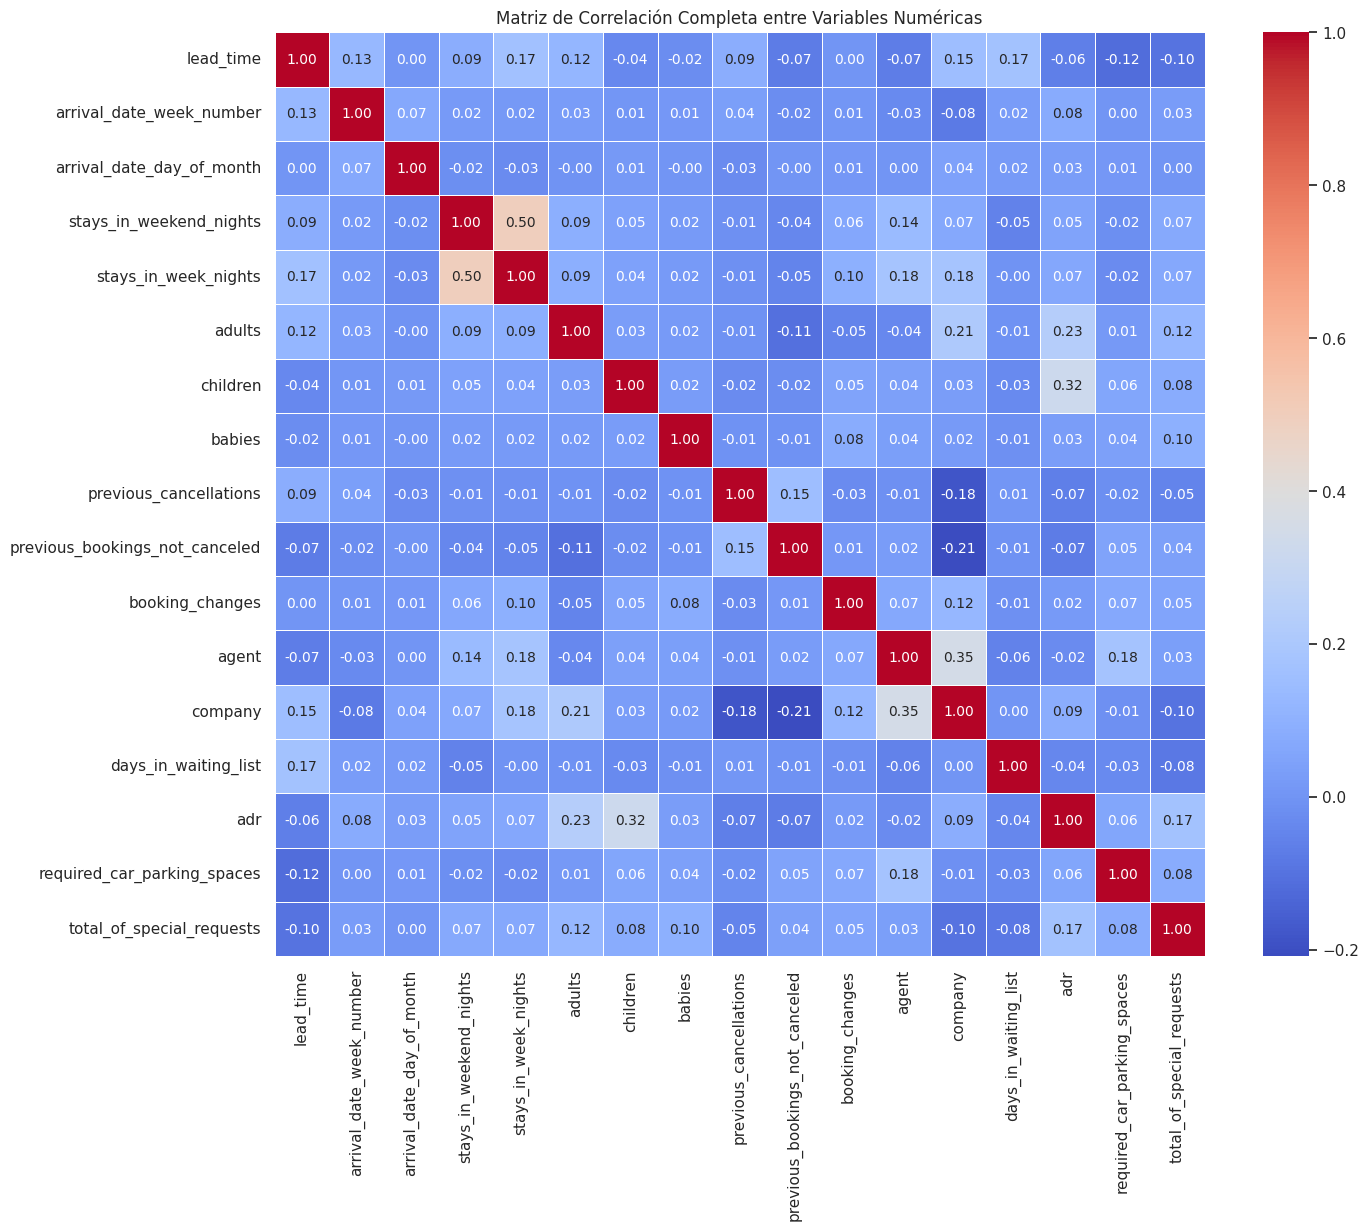

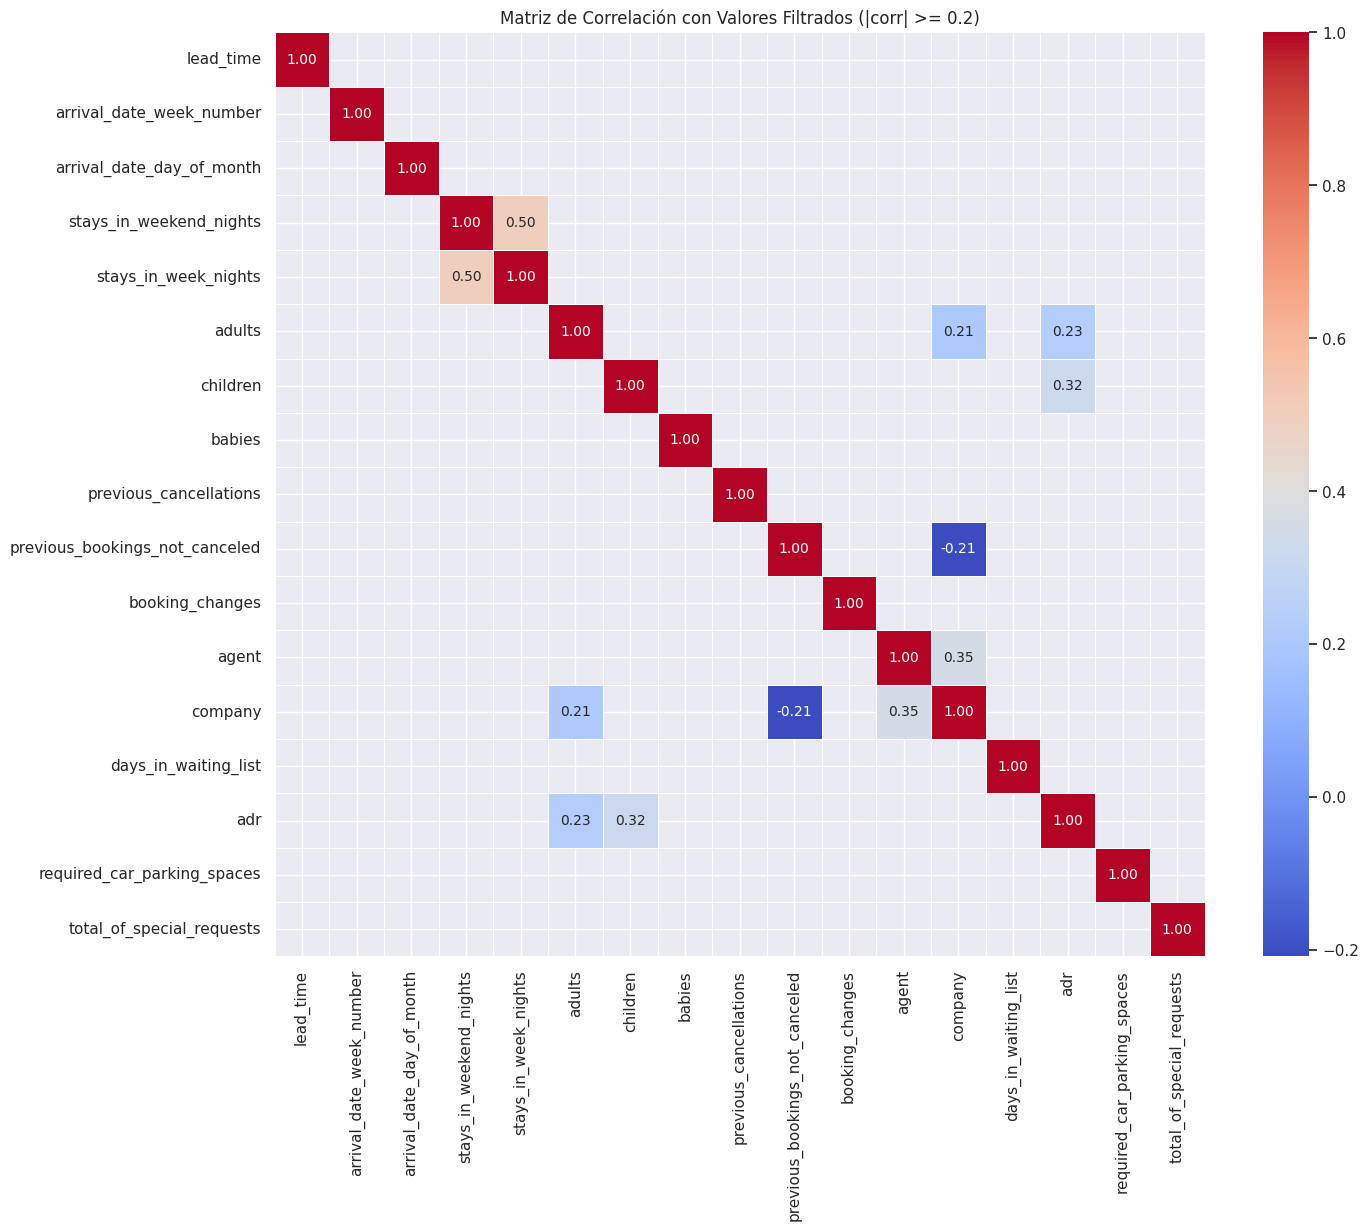

In [ ]:
# ============================================
# 1.b. Exploración: Correlación entre Variables Numéricas
# ============================================

# Seleccionar variables numéricas relevantes
num_vars = ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
            'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
            'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
            'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr',
            'required_car_parking_spaces', 'total_of_special_requests']

# Crear una matriz de correlación
corr_matrix = df[num_vars].corr()

# Crear una máscara para ocultar correlaciones menores a 0.2
mask = np.abs(corr_matrix) < 0.2

# Visualizar la matriz de correlación completa (sin máscara)
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Matriz de Correlación Completa entre Variables Numéricas')
plt.show()

# Visualizar la matriz de correlación enmascarada (valores menores a 0.2 ocultos)
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Matriz de Correlación con Valores Filtrados (|corr| >= 0.2)')
plt.show()



Correlación de variables numéricas con 'is_canceled':
is_canceled                       1.000000
lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_week_number          0.008148
children                          0.005048
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
company                          -0.020642
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
agent                            -0.083114
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64

Correlaciones significativas (|corr| >= 0.1):
is_canceled                    1.000000
lead_time                      0.293123
previous_c

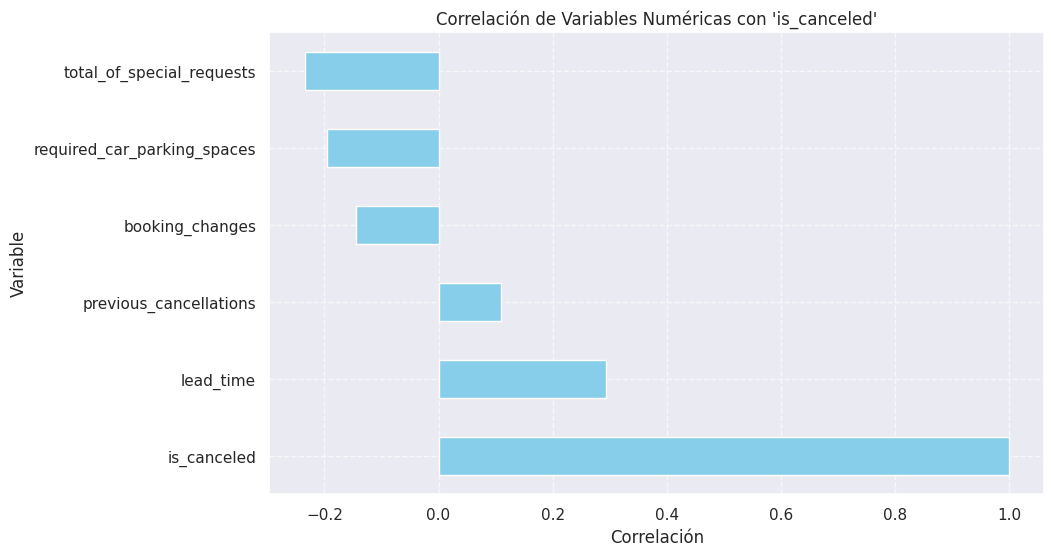

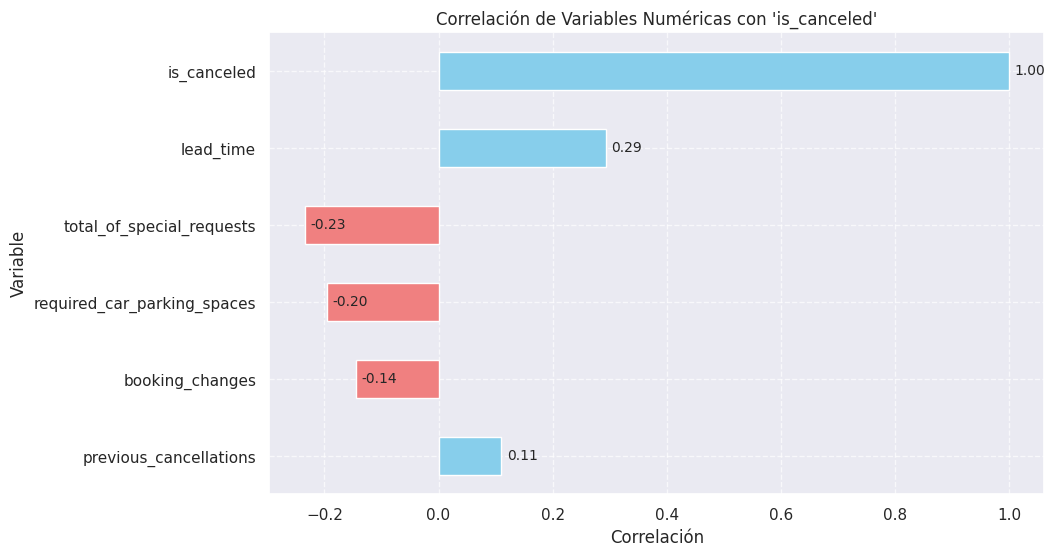

In [ ]:
# Análisis Detallado con Apertura por Cancelación

# Añadir la variable 'is_canceled' al análisis
num_vars_with_target = num_vars + ['is_canceled']

# Calcular la matriz de correlación incluyendo 'is_canceled'
corr_matrix_target = df[num_vars_with_target].corr()

# Extraer correlaciones con 'is_canceled' y ordenarlas
corr_with_target = corr_matrix_target['is_canceled'].sort_values(ascending=False)

print("\nCorrelación de variables numéricas con 'is_canceled':")
print(corr_with_target)

# Filtrar y mostrar correlaciones significativas (|corr| >= 0.1)
significant_corr = corr_with_target[abs(corr_with_target) >= 0.1]
print("\nCorrelaciones significativas (|corr| >= 0.1):")
print(significant_corr)

# Visualización con gráfico de barras horizontal
plt.figure(figsize=(10, 6))
significant_corr.plot(kind='barh', color='skyblue')
plt.title("Correlación de Variables Numéricas con 'is_canceled'")
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Ordenar por el valor absoluto de las correlaciones (opcional)
significant_corr = significant_corr.reindex(significant_corr.abs().sort_values().index)

# Visualización con gráfico de barras horizontal mejorado
plt.figure(figsize=(10, 6))
colors = significant_corr.apply(lambda x: 'skyblue' if x > 0 else 'lightcoral')
ax = significant_corr.plot(kind='barh', color=colors)

# Añadir etiquetas de valor al final de cada barra
for i, v in enumerate(significant_corr):
    ax.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=10)

# Títulos y etiquetas
plt.title("Correlación de Variables Numéricas con 'is_canceled'")
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


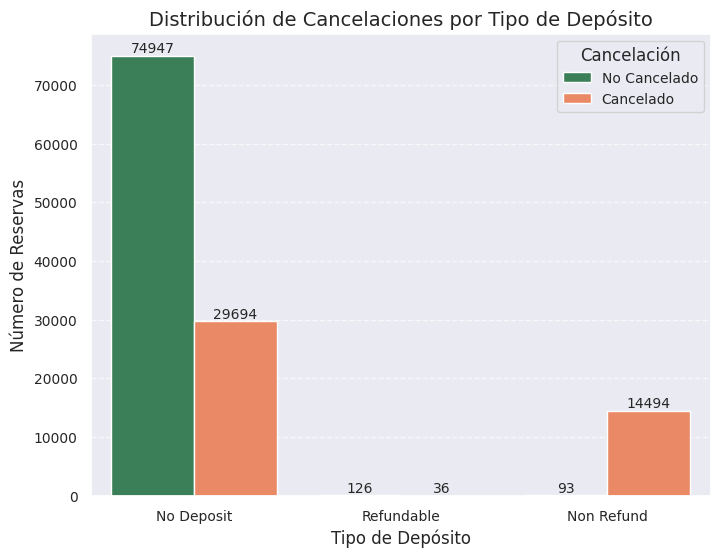

In [ ]:
# ============================================
# 1.c. Exploración: Distribución de la Variable 'is_canceled' por Tipo de Depósito
# ============================================

# Crear figura y gráfico
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='deposit_type', hue='is_canceled', palette=['seagreen', 'coral'])

# Añadir etiquetas con el número de reservas en cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

# Ajustar leyendas y etiquetas
plt.title('Distribución de Cancelaciones por Tipo de Depósito', fontsize=14)
plt.xlabel('Tipo de Depósito', fontsize=12)
plt.ylabel('Número de Reservas', fontsize=12)
plt.legend(title='Cancelación', labels=['No Cancelado', 'Cancelado'], fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.show()


In [ ]:
# ============================================
# 1.c. Exploración: (Extra) Test de Chi Cuadrado entre 'deposit_type' y 'is_canceled'
# ============================================

# Crear tabla de contingencia
contingency_table = pd.crosstab(df['deposit_type'], df['is_canceled'])

# Mostrar la tabla de contingencia para revisar los datos
print("Tabla de Contingencia:\n", contingency_table)

# Realizar el test de Chi cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Mostrar resultados del Test de Chi cuadrado
print("\nResultados del Test de Chi Cuadrado:")
print(f"Chi2: {chi2:.4f}")
print(f"p-value: {p:.4e}")  # Mostrar p-value en notación científica si es muy pequeño
print(f"Grados de libertad (dof): {dof}")
print(f"Frecuencias esperadas:\n{expected}")

# Interpretación del resultado
alpha = 0.05  # Nivel de significancia
if p < alpha:
    print("\nConclusión: Existe una asociación significativa entre 'deposit_type' y 'is_canceled'.")
else:
    print("\nConclusión: No existe una asociación significativa entre 'deposit_type' y 'is_canceled'.")


Tabla de Contingencia:
 is_canceled       0      1
deposit_type              
No Deposit    74947  29694
Non Refund       93  14494
Refundable      126     36

Resultados del Test de Chi Cuadrado:
Chi2: 27677.3292
p-value: 0.0000e+00
Grados de libertad (dof): 2
Frecuencias esperadas:
[[6.58802698e+04 3.87607302e+04]
 [9.18373768e+03 5.40326232e+03]
 [1.01992562e+02 6.00074378e+01]]

Conclusión: Existe una asociación significativa entre 'deposit_type' y 'is_canceled'.


<ipython-input-9-f3e457ccccb9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_canceled', y='lead_time',


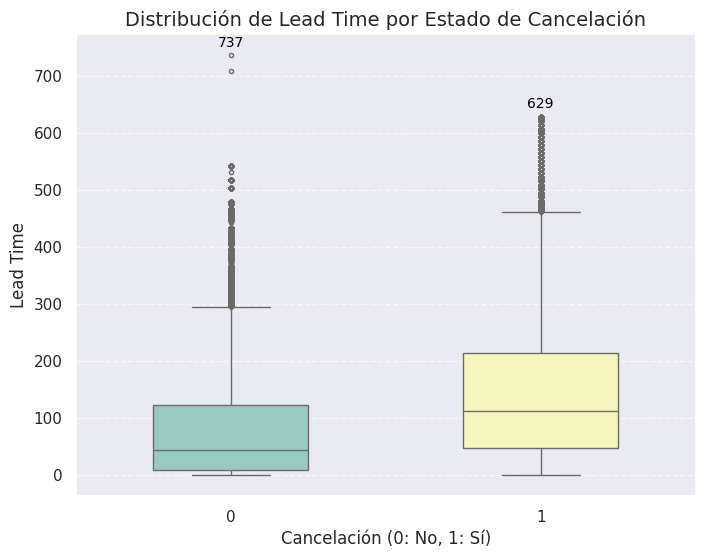

In [ ]:
# ============================================
# 1.d. Exploración: Relación entre 'lead_time' y 'is_canceled'
# ============================================

# Configuración de la figura
plt.figure(figsize=(8, 6))

# Boxplot con personalización
sns.boxplot(data=df, x='is_canceled', y='lead_time',
            palette='Set3', width=0.5, fliersize=3)

# Agregar etiquetas para los valores atípicos más altos
for i in [0, 1]:  # Itera sobre los estados de cancelación
    subset = df[df['is_canceled'] == i]
    max_value = subset['lead_time'].max()
    plt.text(i, max_value + 10, f'{int(max_value)}',
             ha='center', va='bottom', fontsize=10, color='black')

# Ajustes adicionales
plt.title('Distribución de Lead Time por Estado de Cancelación', fontsize=14)
plt.xlabel('Cancelación (0: No, 1: Sí)', fontsize=12)
plt.ylabel('Lead Time', fontsize=12)

# Añadir grid para mayor claridad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


In [ ]:
# ============================================
# 2.a. Partición de Datos: Partición Estratificada de Datos
# ============================================

# a. Partición estratificada entre entrenamiento y test

# Importar librerías necesarias
from sklearn.model_selection import train_test_split

# Definir las variables X (features) y y (target)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

# Semilla aleatoria para replicabilidad (puedes usar tu número si prefieres)
random_seed = 1073247388

# Realizar la partición estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_seed)

# Verificar la proporción de clases en los conjuntos de entrenamiento y prueba
def verificar_proporcion(nombre, y):
    print(f"\nProporción de clases en {nombre}:")
    print(y.value_counts(normalize=True).rename_axis('Clase').reset_index(name='Proporción'))

# Imprimir proporciones
verificar_proporcion('y_train', y_train)
verificar_proporcion('y_test', y_test)



Proporción de clases en y_train:
   Clase  Proporción
0      0    0.629586
1      1    0.370414

Proporción de clases en y_test:
   Clase  Proporción
0      0    0.629575
1      1    0.370425


In [ ]:
# ============================================
# 2.b. Partición de Datos: Generación de Listados de Atributos Predictores
# ============================================

# Atributos numéricos seleccionados
numeric_features = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights',
                    'previous_cancellations', 'previous_bookings_not_canceled',
                    'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces',
                    'total_of_special_requests']

# Atributos categóricos seleccionados
categorical_features = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
                        'distribution_channel', 'reserved_room_type', 'deposit_type',
                        'customer_type']

# Validar que los atributos existen en el DataFrame
missing_numeric = [feat for feat in numeric_features if feat not in df.columns]
missing_categorical = [feat for feat in categorical_features if feat not in df.columns]

if missing_numeric:
    print(f"Advertencia: Los siguientes atributos numéricos no están en el DataFrame: {missing_numeric}")
if missing_categorical:
    print(f"Advertencia: Los siguientes atributos categóricos no están en el DataFrame: {missing_categorical}")

# Imprimir los atributos seleccionados de manera clara
print("\nAtributos numéricos seleccionados (Predictores Numéricos):")
for feature in numeric_features:
    print(f"- {feature}")

print("\nAtributos categóricos seleccionados (Predictores Categóricos):")
for feature in categorical_features:
    print(f"- {feature}")



Atributos numéricos seleccionados (Predictores Numéricos):
- lead_time
- adr
- stays_in_weekend_nights
- stays_in_week_nights
- previous_cancellations
- previous_bookings_not_canceled
- booking_changes
- days_in_waiting_list
- required_car_parking_spaces
- total_of_special_requests

Atributos categóricos seleccionados (Predictores Categóricos):
- hotel
- arrival_date_month
- meal
- country
- market_segment
- distribution_channel
- reserved_room_type
- deposit_type
- customer_type


In [ ]:
# ============================================
# 3.a. Modelos: Ajuste de un Arbol de Clasificación Usando Atributos Categóricos
# ============================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# a. Ajuste de un árbol de clasificación usando los atributos categóricos

# Preprocesamiento: One-Hot Encoding de variables categóricas
X_train_cat = X_train[categorical_features]
X_test_cat = X_test[categorical_features]

# Aplicar One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajustar el encoder en el conjunto de entrenamiento
encoder.fit(X_train_cat)

# Transformar los datos de entrenamiento y prueba
X_train_encoded = encoder.transform(X_train_cat)
X_test_encoded = encoder.transform(X_test_cat)

# Convertir a DataFrame
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_features))
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_features))

# Entrenamiento del modelo
clf = DecisionTreeClassifier(random_state=random_seed)
clf.fit(X_train_encoded, y_train)

# Predicción en el conjunto de prueba
y_pred = clf.predict(X_test_encoded)

# Precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Informe de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Número total de parámetros del modelo
print(f"\nTotal Features Used: {X_train_encoded.shape[1]}")

Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84     15033
           1       0.77      0.60      0.67      8845

    accuracy                           0.79     23878
   macro avg       0.78      0.75      0.76     23878
weighted avg       0.78      0.79      0.78     23878

Confusion Matrix:
[[13452  1581]
 [ 3540  5305]]

Total Features Used: 221


In [ ]:
# ============================================
# 3.c. Modelos: Búsqueda de Hiper-Parámetros, Arbol de Decisión Optimizado con GridSearchCV
# ============================================

# c. Búsqueda de hiperparámetros con cross-validation y grid-search

# Definir el grid de hiperparámetros
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=random_seed),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Ejecutar GridSearchCV
grid_search.fit(X_train_encoded, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nPerformance promedio (F1-Score) del mejor modelo:")
print(grid_search.best_score_)

# Verificar el Rendimiento en el Conjunto de Prueba
y_pred_test = best_model.predict(X_test_encoded)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

# Analizar la Importancia de las Variables
importances = pd.Series(best_model.feature_importances_, index=X_train_encoded.columns)
print(importances.sort_values(ascending=False).head(10))

Mejores hiperparámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Performance promedio (F1-Score) del mejor modelo:
0.6678462029979949
              precision    recall  f1-score   support

           0       0.79      0.89      0.84     15033
           1       0.77      0.60      0.67      8845

    accuracy                           0.79     23878
   macro avg       0.78      0.75      0.76     23878
weighted avg       0.78      0.79      0.78     23878

deposit_type_Non Refund       0.462143
country_PRT                   0.096702
market_segment_Online TA      0.060279
distribution_channel_TA/TO    0.034371
customer_type_Transient       0.021430
arrival_date_month_August     0.012826
arrival_date_month_July       0.011480
arrival_date_month_October    0.011069
meal_HB                       0.010761
hotel_City Hotel              0.009809
dtype: float64


Mejores hiperparámetros encontrados (con atributos numéricos):
{'max_depth': 25, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Performance promedio (F1-Score) del mejor modelo (con atributos numéricos):
0.7883081280370635
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     15033
           1       0.80      0.78      0.79      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.84      0.84     23878
weighted avg       0.85      0.85      0.85     23878

Top 10 Features Más Importantes:
deposit_type_Non Refund        0.274546
lead_time                      0.127489
adr                            0.092039
market_segment_Online TA       0.071891
total_of_special_requests      0.061355
country_PRT                    0.047035
required_car_parking_spaces    0.031289
stays_in_week_nights           0.030842
previous_cancellations         0.021986
stays_in_weekend_nights        0.0

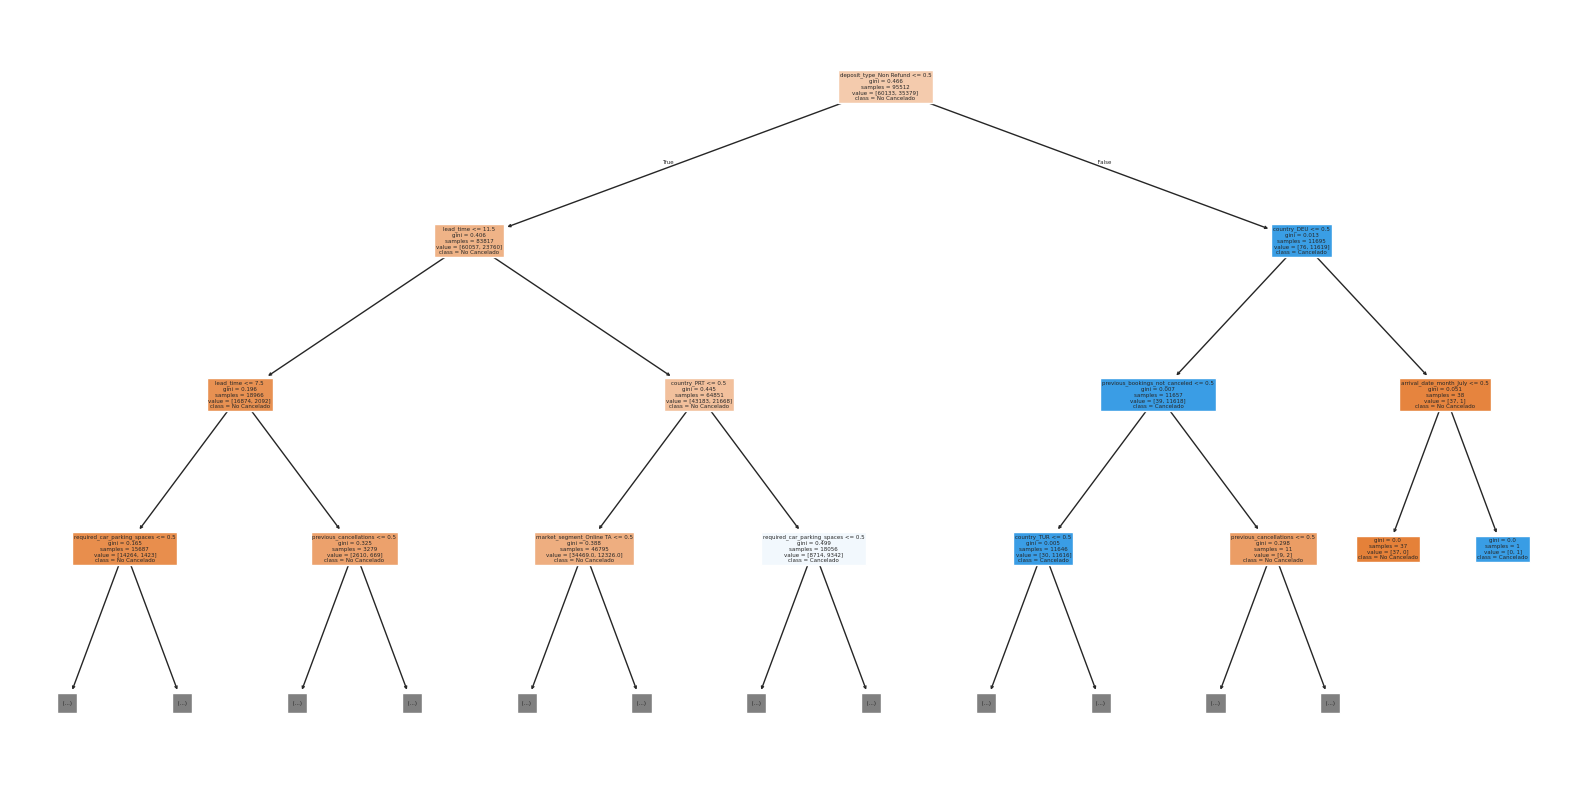

In [ ]:
# ============================================
# 3.d. Modelos:  Optimización del Árbol de Decisión con Atributos Numéricos y Categóricos Combinados
# ============================================

# d. Repetición incluyendo atributos numéricos

# Preprocesamiento de variables numéricas (opcional, si es necesario)
# En este caso, los árboles de decisión no requieren escalado de variables numéricas

X_train_num = X_train[numeric_features]
X_test_num = X_test[numeric_features]

# Combinar atributos categóricos y numéricos
X_train_combined = pd.concat([X_train_encoded.reset_index(drop=True), X_train_num.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test_encoded.reset_index(drop=True), X_test_num.reset_index(drop=True)], axis=1)

# Repetir GridSearchCV con los nuevos datos
grid_search_combined = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=random_seed),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search_combined.fit(X_train_combined, y_train)

# Mejor modelo con atributos numéricos incluidos
best_model_combined = grid_search_combined.best_estimator_

print("Mejores hiperparámetros encontrados (con atributos numéricos):")
print(grid_search_combined.best_params_)

print("\nPerformance promedio (F1-Score) del mejor modelo (con atributos numéricos):")
print(grid_search_combined.best_score_)

# Evaluación en el Conjunto de Prueba
y_pred_combined = best_model_combined.predict(X_test_combined)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_combined))

# Análisis de la Importancia de las Variables:
feature_importances_combined = pd.Series(best_model_combined.feature_importances_, index=X_train_combined.columns)
top_features = feature_importances_combined.sort_values(ascending=False).head(10)
print("Top 10 Features Más Importantes:")
print(top_features)

# Visualización del Árbol de Decisión:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(best_model_combined, max_depth=3, feature_names=X_train_combined.columns, class_names=['No Cancelado', 'Cancelado'], filled=True)
plt.show()

X_train_full shape: (95512, 254)
X_test_full shape: (23878, 254)
Mejores hiperparámetros encontrados (con todos los atributos):
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

Performance promedio (F1-Score) del mejor modelo (con todos los atributos):
0.8244443253909102
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     15033
           1       0.82      0.83      0.83      8845

    accuracy                           0.87     23878
   macro avg       0.86      0.86      0.86     23878
weighted avg       0.87      0.87      0.87     23878

Top 10 Features Más Importantes:
deposit_type_Non Refund        0.308888
lead_time                      0.078584
market_segment_Online TA       0.075216
agent                          0.071570
total_of_special_requests      0.064323
country_PRT                    0.053881
room_type_changed              0.045862
required_car_parking_spaces    0.036145
adr      

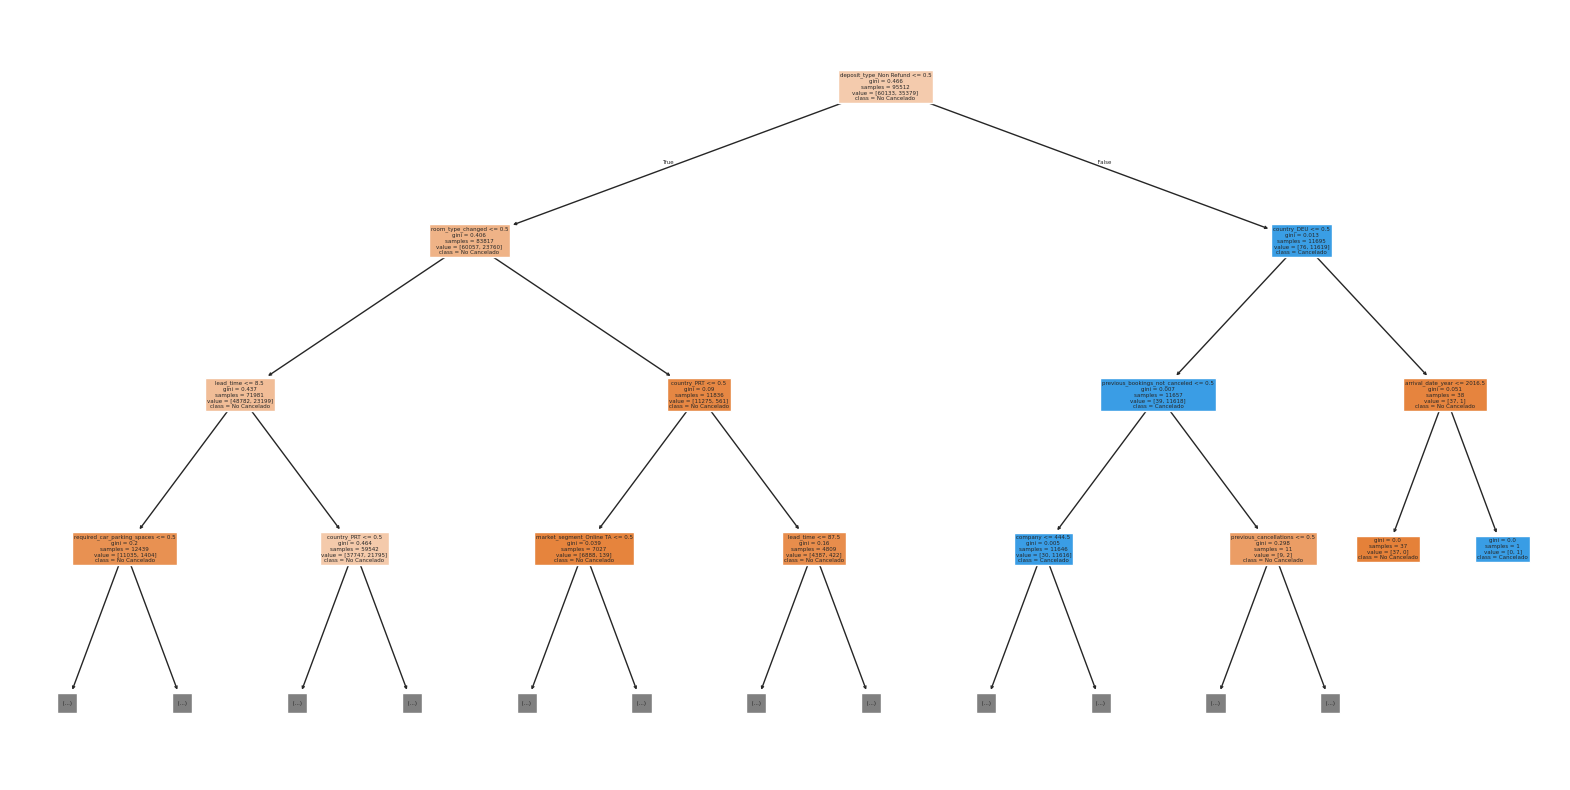

In [ ]:
# ============================================
# 3.e. Modelos: Optimización del Árbol de Decisión con Todos los Atributos Disponibles, Búsqueda de Hiperparámetros Considerando Todos los Atributos
# ============================================

# Verificación de las columnas categóricas y numéricas
all_categorical_features = [col for col in X_train.select_dtypes(include=['object']).columns
                            if col not in ['reservation_status', 'reservation_status_date']]
all_numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento: One-Hot Encoding para variables categóricas
X_train_all_cat = X_train[all_categorical_features]
X_test_all_cat = X_test[all_categorical_features]

encoder_all = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_all.fit(X_train_all_cat)

X_train_all_encoded = encoder_all.transform(X_train_all_cat)
X_test_all_encoded = encoder_all.transform(X_test_all_cat)

# Convertir a DataFrame los datos codificados
X_train_all_encoded = pd.DataFrame(X_train_all_encoded, columns=encoder_all.get_feature_names_out(all_categorical_features))
X_test_all_encoded = pd.DataFrame(X_test_all_encoded, columns=encoder_all.get_feature_names_out(all_categorical_features))

# Asegurarse de que las variables numéricas estén correctamente definidas
X_train_all_num = X_train[all_numeric_features].reset_index(drop=True)
X_test_all_num = X_test[all_numeric_features].reset_index(drop=True)

# Concatenar variables categóricas y numéricas
X_train_full = pd.concat([X_train_all_encoded, X_train_all_num], axis=1)
X_test_full = pd.concat([X_test_all_encoded, X_test_all_num], axis=1)

# Verificar la forma de los datos combinados
print(f"X_train_full shape: {X_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}")

# Repetir GridSearchCV con todos los atributos
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Configurar GridSearchCV
grid_search_full = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=random_seed),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Ajustar el modelo con los datos combinados
grid_search_full.fit(X_train_full, y_train)

# Mejor modelo encontrado
best_model_full = grid_search_full.best_estimator_

print("Mejores hiperparámetros encontrados (con todos los atributos):")
print(grid_search_full.best_params_)

print("\nPerformance promedio (F1-Score) del mejor modelo (con todos los atributos):")
print(grid_search_full.best_score_)

# Evaluación en el Conjunto de Prueba
y_pred_full = best_model_full.predict(X_test_full)
print(classification_report(y_test, y_pred_full))

# Análisis de la Importancia de las Características
feature_importances_full = pd.Series(best_model_full.feature_importances_, index=X_train_full.columns)
top_features_full = feature_importances_full.sort_values(ascending=False).head(10)
print("Top 10 Features Más Importantes:")
print(top_features_full)

# Visualización del Árbol de Decisión (opcional)
plt.figure(figsize=(20,10))
plot_tree(best_model_full, max_depth=3, feature_names=X_train_full.columns,
          class_names=['No Cancelado', 'Cancelado'], filled=True)
plt.show()


In [ ]:
# ============================================
# 3.b. Modelos: Evaluación Comparativa de Modelos con Múltiples Métricas
# ============================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Función para evaluar los modelos con múltiples métricas
def evaluar_modelo(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.2f}")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_true, y_pred))

# Comparación de performance entre los modelos
print("\nEvaluación del modelo categórico:")
try:
    evaluar_modelo(y_test, grid_search.best_estimator_.predict(X_test_encoded))
except NameError:
    print("El modelo categórico no está definido.")

print("\nEvaluación del modelo categórico + numérico:")
try:
    evaluar_modelo(y_test, grid_search_combined.best_estimator_.predict(X_test_combined))
except NameError:
    print("El modelo categórico + numérico no está definido.")

print("\nEvaluación del modelo con todos los atributos:")
try:
    evaluar_modelo(y_test, best_model_full.predict(X_test_full))
except NameError:
    print("El modelo con todos los atributos no está definido.")



Evaluación del modelo categórico:
Accuracy: 0.79
Precision: 0.77
Recall: 0.60
F1-Score: 0.67
Matriz de Confusión:
[[13452  1581]
 [ 3540  5305]]

Evaluación del modelo categórico + numérico:
Accuracy: 0.85
Precision: 0.80
Recall: 0.78
F1-Score: 0.79
Matriz de Confusión:
[[13345  1688]
 [ 1912  6933]]

Evaluación del modelo con todos los atributos:
Accuracy: 0.87
Precision: 0.82
Recall: 0.83
F1-Score: 0.83
Matriz de Confusión:
[[13458  1575]
 [ 1462  7383]]


In [ ]:
# 3.b. Elección de la Métrica de Performance

# La elección de métricas múltiples para evaluar los modelos es crucial en la clasificación,
# especialmente en contextos donde el desbalance de clases podría afectar significativamente el rendimiento del modelo.
# En este contexto, no sólo nos interesa la precisión general del modelo (Accuracy),
# sino también cómo el modelo se desempeña en términos de su habilidad para identificar cada clase correctamente.
# Por esto, se incluyen métricas como Precision, Recall y F1-Score:
# - Precision nos informa sobre la exactitud de las predicciones positivas.
# - Recall indica la capacidad del modelo para encontrar todos los casos positivos (sensibilidad).
# - F1-Score proporciona un balance entre Precision y Recall, siendo particularmente útil en situaciones de desbalance de clases.
# Estas métricas, junto con la matriz de confusión, nos permiten tener una visión más completa y detallada del rendimiento del modelo,
# permitiendo ajustes más informados en el proceso de modelado.


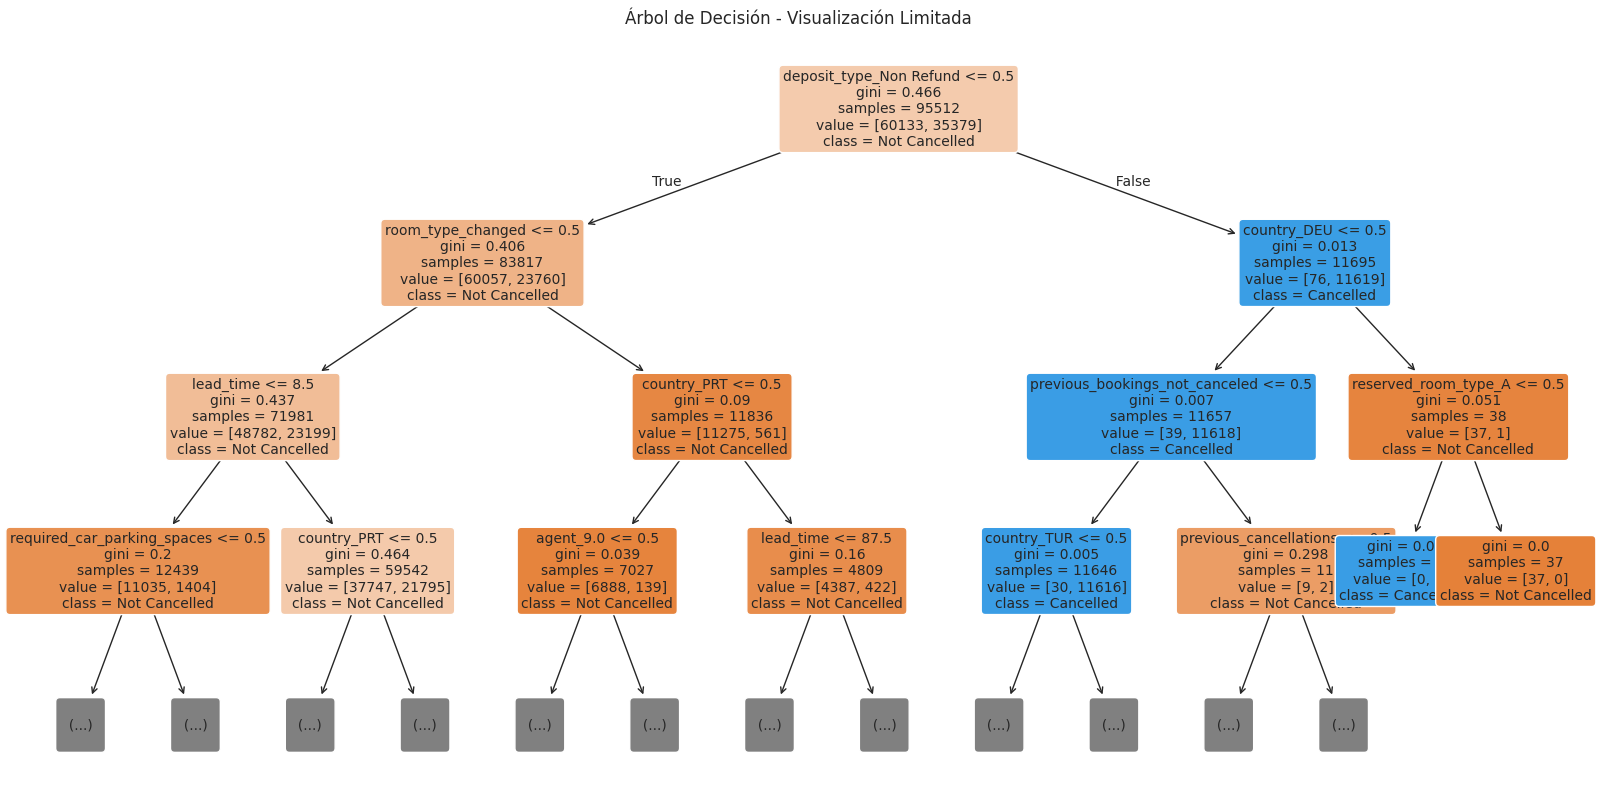

In [ ]:
# ============================================
# 4.a. Importancia de Features y Testing: Gráfica del Árbol de Mejor Rendimiento
# ============================================

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura para acomodar un árbol grande
plt.figure(figsize=(20, 10))

# Dibujar el árbol con un límite de profundidad para simplificar la visualización
plot_tree(best_model_full,
          filled=True,
          rounded=True,
          max_depth=3, # Puedes ajustar esto para ver más o menos detalles del árbol
          feature_names=X_train_full.columns, # Asegúrate de que esto coincide con las columnas del conjunto de entrenamiento
          class_names=['Not Cancelled', 'Cancelled'],
          fontsize=10) # Ajusta el tamaño de fuente si es necesario

plt.title('Árbol de Decisión - Visualización Limitada')
plt.show()


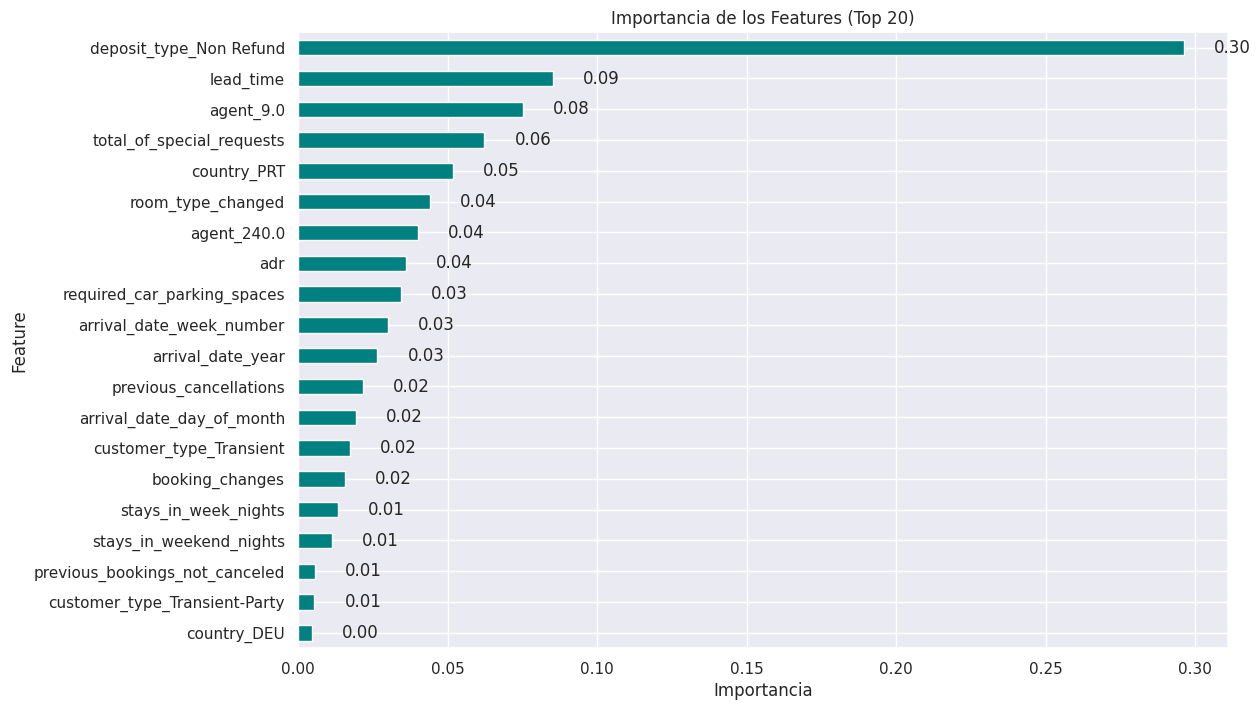


Top 10 Features Más Importantes:
deposit_type_Non Refund        0.296143
lead_time                      0.085228
agent_9.0                      0.075033
total_of_special_requests      0.062305
country_PRT                    0.051657
room_type_changed              0.043965
agent_240.0                    0.040037
adr                            0.036078
required_car_parking_spaces    0.034326
arrival_date_week_number       0.029992
dtype: float64


In [ ]:
# ============================================
# 4.b. Importancia de Features y Testing: Importancia de Caracteristicas y Evaluación Final
# ============================================

# b. Importancia de los features

# Obtener importancias
feature_importances = pd.Series(best_model_full.feature_importances_, index=X_train_full.columns)

# Ordenar importancias
feature_importances = feature_importances.sort_values(ascending=False)

# Exportar a CSV (opcional, útil para análisis posterior)
feature_importances.to_csv('importancia_features.csv')

# Graficar importancias con etiquetas
plt.figure(figsize=(12,8))
ax = feature_importances.head(20).plot(kind='barh', color='teal')
plt.title('Importancia de los Features (Top 20)')
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.ylabel('Feature')

# Añadir etiquetas de valores en las barras
for i, v in enumerate(feature_importances.head(20)):
    ax.text(v + 0.01, i, f"{v:.2f}", va='center')

# Mostrar gráfico
plt.show()

# Comentarios adicionales
print("\nTop 10 Features Más Importantes:")
print(feature_importances.head(10))

# Sugerencia:
# Verificar las variables más importantes y analizar su relación con 'is_canceled'



Métricas en el conjunto de prueba:
Accuracy: 0.8692
Recall: 0.8127
Precision: 0.8305
F1-Score: 0.8215
ROC-AUC: 0.9096


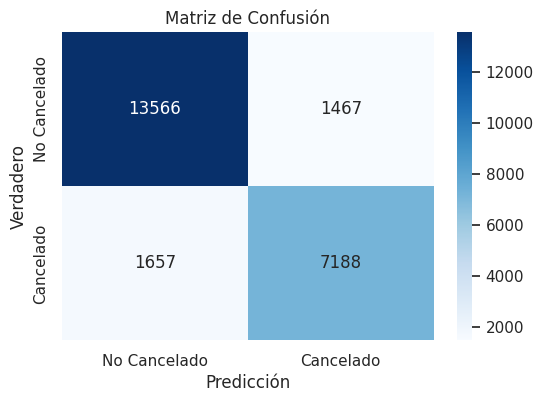

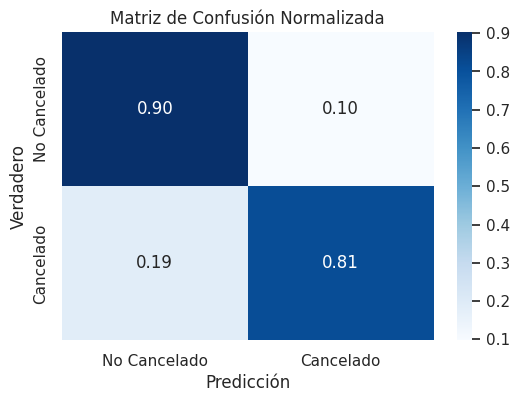

In [ ]:
# ============================================
# 4.c. Importancia de Features y Testing: Entrenamiento con Todo el Conjunto de Datos, Evaluación Exhaustiva del Modelo con Métricas y Matrices de Confusión
# ============================================

# Importar las métricas necesarias
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# Entrenamiento del modelo con todo el conjunto de datos de entrenamiento
best_model_full.fit(X_train_full, y_train)

# Predicciones en el conjunto de prueba
y_pred = best_model_full.predict(X_test_full)

# Cálculo de métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model_full.predict_proba(X_test_full)[:, 1])

print("Métricas en el conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['No Cancelado', 'Cancelado'],
            yticklabels=['No Cancelado', 'Cancelado'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

# Matriz de Confusión Normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['No Cancelado', 'Cancelado'],
            yticklabels=['No Cancelado', 'Cancelado'])
plt.title('Matriz de Confusión Normalizada')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()



Métricas del Random Forest Default en el conjunto de prueba:
Accuracy: 0.8958
Recall: 0.8185
Precision: 0.8912

Comparación de Random Forest Default vs. Mejor Árbol de Decisión:
Árbol de Decisión - Accuracy: 0.8692, Recall: 0.8127, Precision: 0.8305
Random Forest - Accuracy: 0.8958, Recall: 0.8185, Precision: 0.8912


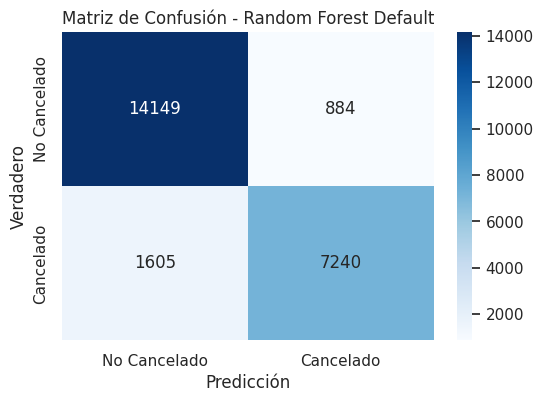

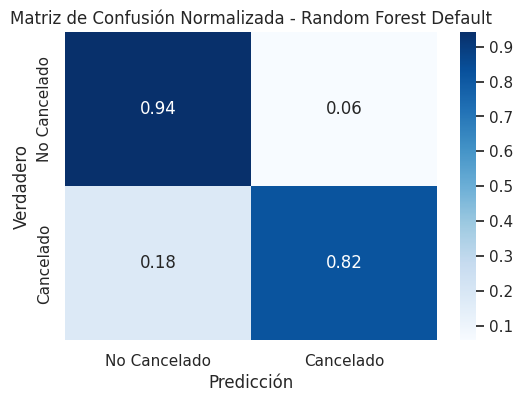

In [ ]:
# ============================================
# 5.a. Ensambles: Modelo Random Forest, Comparación de Desempeño vs. Árbol de Decisión Óptimo
# ============================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ajuste del modelo Random Forest con configuraciones por defecto
rf_default = RandomForestClassifier(random_state=random_seed)
rf_default.fit(X_train_full, y_train)

# Evaluación en el conjunto de test
y_pred_rf = rf_default.predict(X_test_full)

# Cálculo de métricas para Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)

print("\nMétricas del Random Forest Default en el conjunto de prueba:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")

# Suponiendo que 'best_model_full' es el mejor árbol de decisión obtenido previamente
y_pred_tree = best_model_full.predict(X_test_full)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)

# Comparación de Random Forest con el mejor árbol de decisión
print("\nComparación de Random Forest Default vs. Mejor Árbol de Decisión:")
print(f"Árbol de Decisión - Accuracy: {accuracy_tree:.4f}, Recall: {recall_tree:.4f}, Precision: {precision_tree:.4f}")
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}, Recall: {recall_rf:.4f}, Precision: {precision_rf:.4f}")

# Matriz de confusión para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.title('Matriz de Confusión - Random Forest Default')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

# Matriz de Confusión Normalizada
cm_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['No Cancelado', 'Cancelado'],
            yticklabels=['No Cancelado', 'Cancelado'])
plt.title('Matriz de Confusión Normalizada - Random Forest Default')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()
